# Inferring labels

This notebook shows how to construct reasoning chains to infer the target label set. It is helpful when you don't know which ontology might be presented in the dataset of interest. The typical approach is to look at each individual example and add a new category to the ontology when met. But this manual approach can be automated. 

To give an example, let's load a dataset of news:

In [1]:
import pandas as pd
from datasets import load_dataset

ds = load_dataset('ag_news', 'default')
df = pd.DataFrame(data=ds['train'][:1000]['text'], columns=['text'])
df

text
0    Wall St. Bears Claw Back Into the Black (Reute...
1    Carlyle Looks Toward Commercial Aerospace (Reu...
2    Oil and Economy Cloud Stocks' Outlook (Reuters...
3    Iraq Halts Oil Exports from Main Southern Pipe...
4    Oil prices soar to all-time record, posing new...
..                                                 ...
995  U.S. Stocks Rebound as Oil Prices Ease  NEW YO...
996  Dollar Rises Vs Euro After Asset Data  NEW YOR...
997  Bikes Bring Internet to Indian Villagers (AP) ...
998  Celebrity Chefs Are Everywhere in Vegas By ADA...
999  Entertainment World Wary of Microsoft Technolo...

[1000 rows x 1 columns]

# Label creation agent

The first agent receives raw texts from the news dataset and determines the best label set for the given target. 

For example:

In [2]:
target = 'help analysts identify the primary reason for changes in the stock market.'

To create the possible label set that fits this target, agent's reasoning path consists of 2 stages:

1. `onto_creator` - create possible candidates for labels;
2. `onto_merger` - merge label candidates with similar semantics

In [3]:
from adala.agents import Agent
from adala.runtimes import OpenAIChatRuntime
from adala.skills import OntologyCreator, OntologyMerger, LinearSkillSet

a = Agent(
    skills=LinearSkillSet(skills=[
        OntologyCreator(target=target),
        OntologyMerger(target=target)
    ]),
    runtimes={
        'gpt4': OpenAIChatRuntime(model='gpt-4-1106-preview', verbose=False)
    },
    default_runtime='gpt4')

pred = a.run(df)
labels = [l.strip() for l in pred.labels[0].split('\n')]
print(labels)

Applying skill: onto_creator

Processing chunks: 100%|██████████████████████| 5/5 [00:20<00:00,  4.12s/it]


 categories                             
 ─────────────────────────────────────── 
  Economic Factors                       
  Market Trends                          
  Corporate News and Events              
  Commodity Prices                       
  Geopolitical Events                    
  Market Trends and Performance          
  Technological Innovations              
  Consumer Behavior                      
  Corporate Strategy                     
  Legal and Regulatory Issues            
  Technology and Computing               
  Economics and Business                 
  Legal and Crimes                       
  Politics                               
  Science and Environment                
  Macro-economic Factors                 
  Geopolitical Events                    
  Natural Disasters                      
  Company News                           
  Investment & Trading Activities        
  Corporate Earnings                     
  Commodity Prices                       
  Mergers and Acquisitions               
  Natural Disasters and Weather Events   
  Technological Innovations and Updates

Applying skill: onto_merger

Processing chunks: 1it [00:03,  3.50s/it]


 labels                       
 ───────────────────────────── 
  Economic Factors             
  Market Trends                
  Corporate News and Events    
  Commodity Prices             
  Geopolitical Events          
  Technological Innovations    
  Consumer Behavior            
  Corporate Strategy           
  Legal and Regulatory Issues  
  Natural Disasters

['Economic Factors', 'Market Trends', 'Corporate News and Events', 'Commodity Prices', 'Geopolitical Events', 'Technological Innovations', 'Consumer Behavior', 'Corporate Strategy', 'Legal and Regulatory Issues', 'Natural Disasters']


# Classification agent

Now, given the label set, we can run classification skills to obtain the prediction for each news

Applying skill: classification

100%|█████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


 label                  
 ─────────────────────── 
  Corporate Performance  
  Product Announcements  
  Product Announcements  
  Technology Trends      
  Regulatory Policy

<Axes: ylabel='count'>

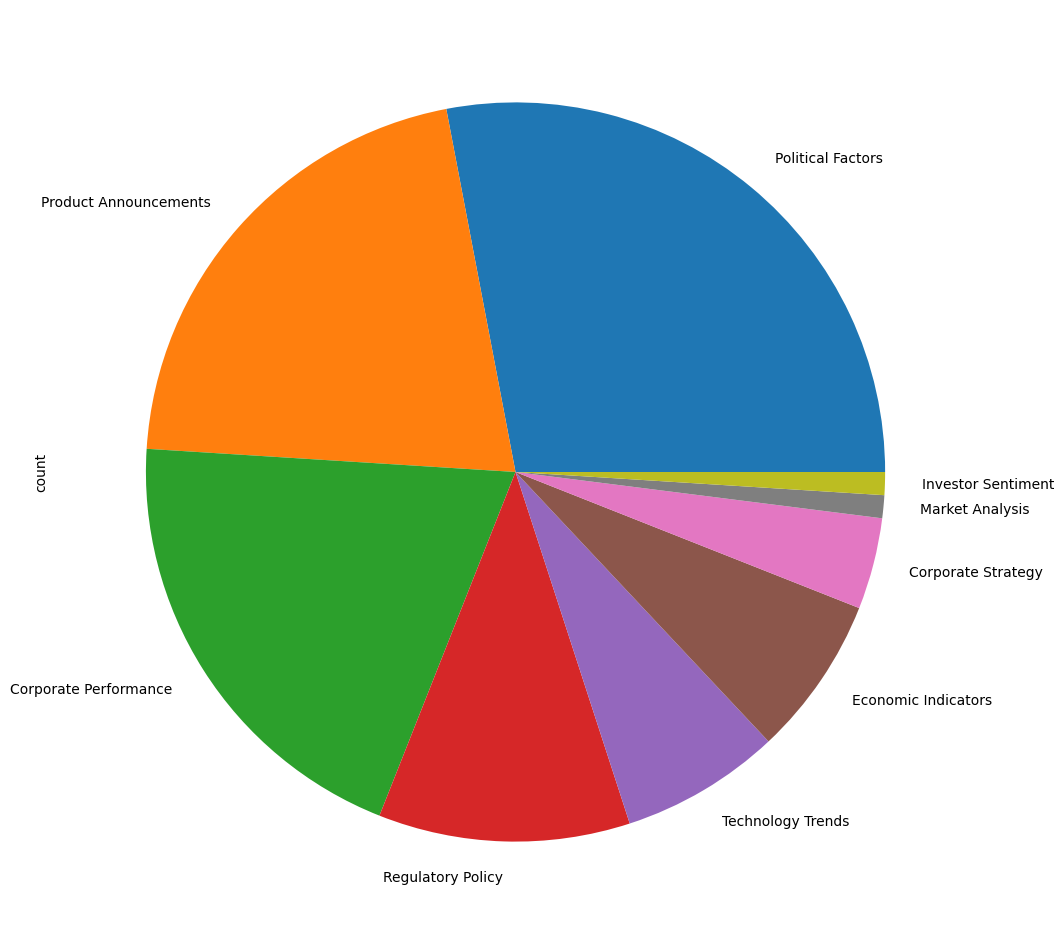

In [7]:
from adala.skills import ClassificationSkill

predictor = Agent(
    skills=LinearSkillSet(skills=[ClassificationSkill(labels={'label': labels})]),
    runtimes={
        'default': OpenAIChatRuntime(model='gpt-4-1106-preview', verbose=False)
    })

df_test = pd.DataFrame(data=ds['test'][:100]['text'], columns=['text'])

pred_test = predictor.run(df_test)
pred_test.label.value_counts().plot.pie(figsize=(12, 12))